# Database population Script

## Populating the DB

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ta.momentum
import ta.trend
import yfinance as yf
import sklearn as sk
import sklearn.preprocessing
import os
import sys
import time
from IPython.display import clear_output

In [135]:
NUM_TICKERS = 50
# Get the data for the top companies in the S&P 500
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
table = data[0]
# Get the top 50 companies and assigning them a unique id
tickers = {table.index[i]: table['Symbol'][i] for i in range(NUM_TICKERS)}
tickers

{0: 'MMM',
 1: 'AOS',
 2: 'ABT',
 3: 'ABBV',
 4: 'ACN',
 5: 'ADBE',
 6: 'AMD',
 7: 'AES',
 8: 'AFL',
 9: 'A',
 10: 'APD',
 11: 'ABNB',
 12: 'AKAM',
 13: 'ALB',
 14: 'ARE',
 15: 'ALGN',
 16: 'ALLE',
 17: 'LNT',
 18: 'ALL',
 19: 'GOOGL',
 20: 'GOOG',
 21: 'MO',
 22: 'AMZN',
 23: 'AMCR',
 24: 'AMTM',
 25: 'AEE',
 26: 'AEP',
 27: 'AXP',
 28: 'AIG',
 29: 'AMT',
 30: 'AWK',
 31: 'AMP',
 32: 'AME',
 33: 'AMGN',
 34: 'APH',
 35: 'ADI',
 36: 'ANSS',
 37: 'AON',
 38: 'APA',
 39: 'AAPL',
 40: 'AMAT',
 41: 'APTV',
 42: 'ACGL',
 43: 'ADM',
 44: 'ANET',
 45: 'AJG',
 46: 'AIZ',
 47: 'T',
 48: 'ATO',
 49: 'ADSK'}

In [136]:
# Download the data for each company
data_pds = {}

# if data.csv does not exist, download the data
if not os.path.exists("data.csv"):
    print("Downloading data...")
    for ticker_id, ticker in tickers.items():
        clear_output(wait=True)
        sys.stdout.write(f"\rDownloading data for {ticker} ({ticker_id + 1}/{NUM_TICKERS})")
        time.sleep(0.1)
        data = yf.download(ticker, progress=False, end="2024-11-27")
        data = data.reset_index()
        data.columns = data.columns.droplevel(1)
        data = data.rename_axis("Index")

        # Add the ticker ID to the data
        data["Ticker_ID"] = ticker_id

        # turning raw date into year, month, day columns
        data['Year'] = data['Date'].dt.year
        data['Month'] = data['Date'].dt.month
        data['Day'] = data['Date'].dt.day

        close_data = data['Close'].squeeze()
        data['SMA_20'] = ta.trend.sma_indicator(close_data, window=20) # 20 day simple moving average
        data['RSI_14'] = ta.momentum.rsi(close_data, window=14) # 14 day RSI

        bbands = ta.volatility.BollingerBands(close_data, window=20) # 20 day Bollinger Bands
        data["BB_Upper"] = bbands.bollinger_hband() # upper band
        data["BB_Middle"] = bbands.bollinger_mavg() # middle band
        data["BB_Lower"] = bbands.bollinger_lband() # lower band

        macd = ta.trend.MACD(close_data) # MACD
        data["MACD"] = macd.macd() # MACD line
        data["Signal"] = macd.macd_signal() # Signal line

        data["ATR"] = ta.volatility.average_true_range(data['High'].squeeze(), data['Low'].squeeze(), close_data, window=14) # 14 day ATR

        data_pds[ticker] = data.dropna()

    # combine the data
    data = pd.concat(data_pds.values())

    # looking at the future change; 1 if the price goes up, 0 if the price goes down
    data['Future_Change_Price'] = data.groupby('Ticker_ID')['Close'].shift(-1)
    data['Future_Change'] = (data['Future_Change_Price'] > data['Close']).astype(int)

    data.to_csv("data.csv")
else:
    print("Data already downloaded.")

Data already downloaded.


In [137]:
data = pd.read_csv("data.csv")
data.drop(columns=["Index"], inplace=True)
data["Date"] = pd.to_datetime(data["Date"])
data = data.dropna()

data[data["Ticker_ID"] == 19].tail(10)

,Date,Adj Close,Close,High,Low,Open,Volume,Ticker_ID,Year,Month,...,SMA_20,RSI_14,BB_Upper,BB_Middle,BB_Lower,MACD,Signal,ATR,Future_Change_Price,Future_Change
160691,2024-11-12,181.619995,181.619995,182.490005,179.389999,179.820007,25134900,19,2024,11,...,170.065501,70.250600,182.769918,170.065501,157.361083,4.263594,2.979155,3.761776,178.880005,0
160692,2024-11-13,178.880005,178.880005,180.960007,178.539993,180.460007,23184000,19,2024,11,...,170.751501,63.925647,183.799342,170.751501,157.703660,4.268273,3.236978,3.713078,175.580002,0
160693,2024-11-14,175.580002,175.580002,178.820007,174.320007,178.279999,31007500,19,2024,11,...,171.384001,57.241192,184.075479,171.384001,158.692523,3.960048,3.381592,3.773573,172.490005,0
160694,2024-11-15,172.490005,172.490005,174.139999,171.220001,173.729996,32504600,19,2024,11,...,171.837502,51.781208,183.995238,171.837502,159.679765,3.426938,3.390661,3.815460,175.300003,1
160695,2024-11-18,175.300003,175.300003,175.440002,172.899994,173.419998,20206600,19,2024,11,...,172.399001,55.900729,184.098592,172.399001,160.699411,3.194365,3.351402,3.753641,178.119995,1
160696,2024-11-19,178.119995,178.119995,178.869995,173.559998,173.720001,23434900,19,2024,11,...,173.048001,59.628364,184.502386,173.048001,161.593616,3.200703,3.321262,3.864810,175.979996,0
160697,2024-11-20,175.979996,175.979996,177.679993,173.779999,177.339996,18997100,19,2024,11,...,173.708001,55.775399,184.200545,173.708001,163.215457,2.998482,3.256706,3.898752,167.630005,0
160698,2024-11-21,167.630005,167.630005,174.130005,163.699997,173.899994,59734400,19,2024,11,...,173.953501,43.865193,183.602003,173.953501,164.304999,2.139779,3.033321,4.497412,164.759995,0
160699,2024-11-22,164.759995,164.759995,166.460007,163.899994,165.850006,38604600,19,2024,11,...,173.928001,40.651973,183.670407,173.928001,164.185595,1.213675,2.669392,4.442598,167.649994,1
160700,2024-11-25,167.649994,167.649994,168.630005,165.610001,166.089996,33135300,19,2024,11,...,173.974500,45.019429,183.586859,173.974500,164.362141,0.704805,2.276474,4.401699,169.119995,1


In [138]:
# split the data into training and testing data
train_data = data[data['Year'] < 2018]
X_train = train_data[data.columns.drop(['Date', 'Future_Change', 'Future_Change_Price'])].copy()
y_train = train_data['Future_Change_Price']
y_train_class = train_data['Future_Change']

test_data = data[data['Year'] >= 2018]
X_test = test_data[data.columns.drop(['Date', 'Future_Change', 'Future_Change_Price'])].copy()
y_test = test_data['Future_Change_Price']
y_test_class = test_data['Future_Change']

print(max(data[data['Ticker_ID']==0]['Volume']))
test_data

60436750


,Date,Adj Close,Close,High,Low,Open,Volume,Ticker_ID,Year,Month,...,SMA_20,RSI_14,BB_Upper,BB_Middle,BB_Lower,MACD,Signal,ATR,Future_Change_Price,Future_Change
14064,2018-01-02,151.698517,197.023407,198.219070,194.657196,197.140472,3505476,0,2018,1,...,198.466137,50.343905,201.221220,198.466137,195.711054,0.479754,1.046391,2.343375,197.015045,0
14065,2018-01-03,151.692078,197.015045,197.098663,195.058533,196.546829,2623665,0,2018,1,...,198.314381,50.309525,201.037919,198.314381,195.590842,0.404823,0.918078,2.321715,199.590302,1
14066,2018-01-04,153.674911,199.590302,200.200668,197.717392,198.160538,2682748,0,2018,1,...,198.333193,59.485760,201.086366,198.333193,195.580020,0.546935,0.843849,2.383423,201.145493,1
14067,2018-01-05,154.872345,201.145493,201.421402,198.779266,199.540131,2195736,0,2018,1,...,198.412625,63.829768,201.385344,198.412625,195.439906,0.776105,0.830300,2.401902,200.493317,0
14068,2018-01-08,154.370193,200.493317,201.454849,199.983276,200.150497,2235324,0,2018,1,...,198.391304,60.881714,201.297156,198.391304,195.485452,0.894784,0.843197,2.335450,201.739136,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418425,2024-11-19,305.200012,305.200012,306.399994,298.019989,298.130005,1348200,49,2024,11,...,296.805000,60.853917,317.108459,296.805000,276.501541,6.999640,7.353514,6.433390,307.839996,1
418426,2024-11-20,307.839996,307.839996,308.380005,303.149994,305.929993,1441900,49,2024,11,...,297.882001,62.886105,318.127343,297.882001,277.636658,6.929900,7.268791,6.347434,315.410004,1
418427,2024-11-21,315.410004,315.410004,317.450012,308.250000,310.000000,1602100,49,2024,11,...,299.364001,68.013756,320.177329,299.364001,278.550674,7.400162,7.295065,6.580476,321.269989,1
418428,2024-11-22,321.269989,321.269989,321.899994,315.040009,315.959991,1905300,49,2024,11,...,301.125500,71.317347,323.062952,301.125500,279.188049,8.151732,7.466399,6.600441,319.390015,0


Text(0, 0.5, 'Stock Price ($)')

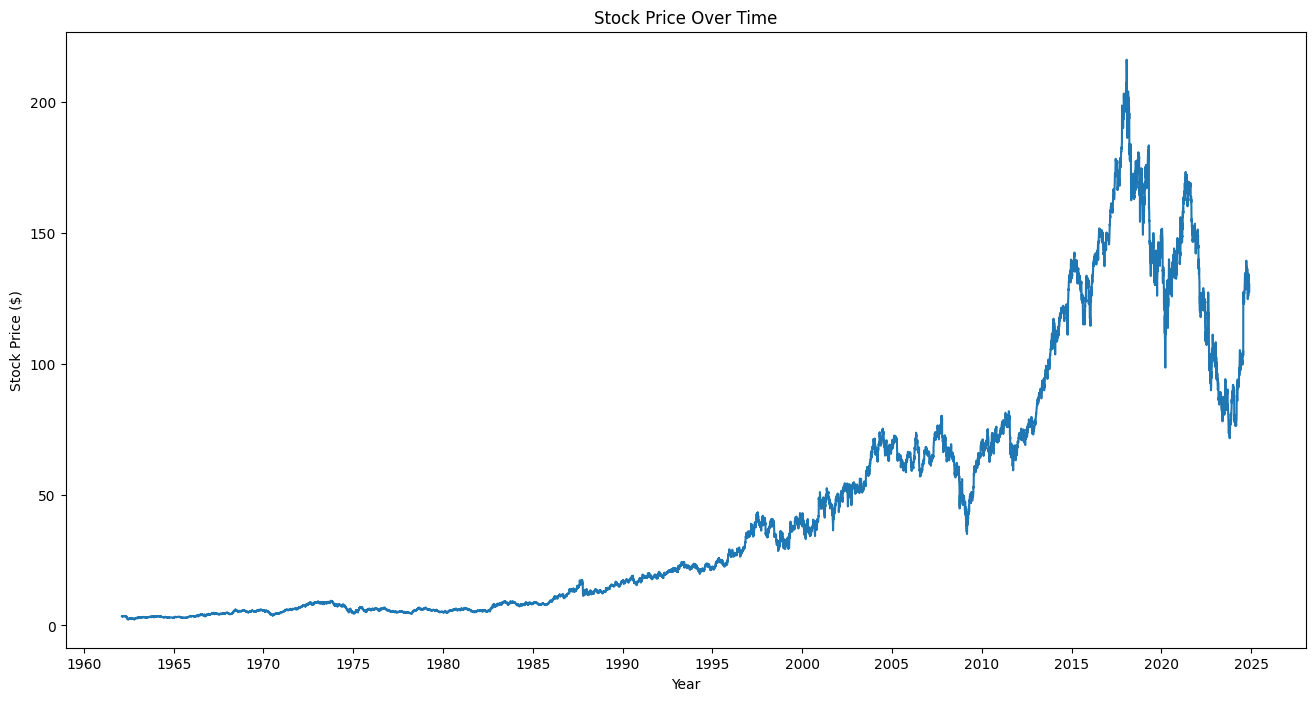

In [139]:
#visualize the data by plotting the stock price over time
plt.figure(figsize=(16, 8))
ticker_id = 0
ticker_data = data[data['Ticker_ID'] == ticker_id]
plt.plot(ticker_data['Date'], ticker_data['Close'])
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

# making the xticks every 10 years
plt.title("Stock Price Over Time")
plt.xlabel("Year")
plt.ylabel("Stock Price ($)")

Text(0, 0.5, 'Volume')

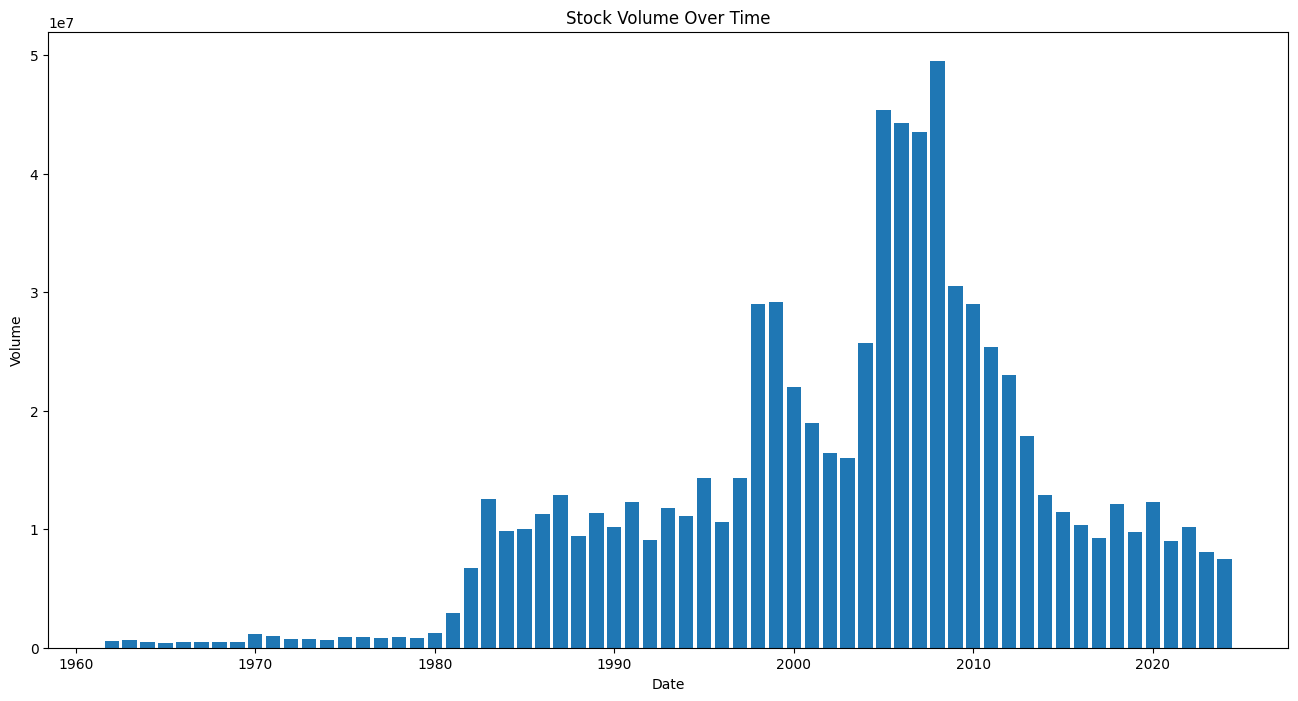

In [140]:
#Plot the average volume of stocks over time; grouped by year
plt.figure(figsize=(16, 8))

plt.bar(data.groupby('Year')['Volume'].mean().index, data.groupby('Year')['Volume'].mean())

plt.title("Stock Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")

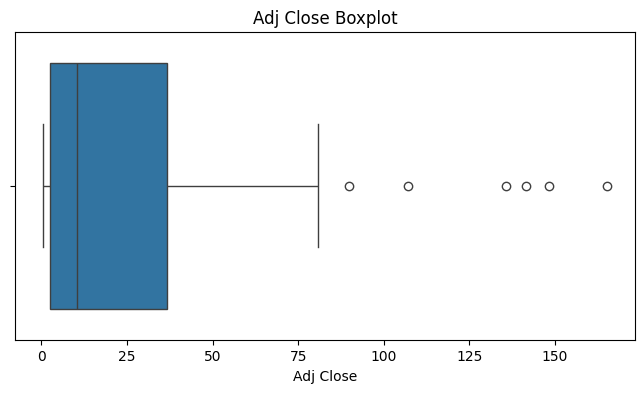

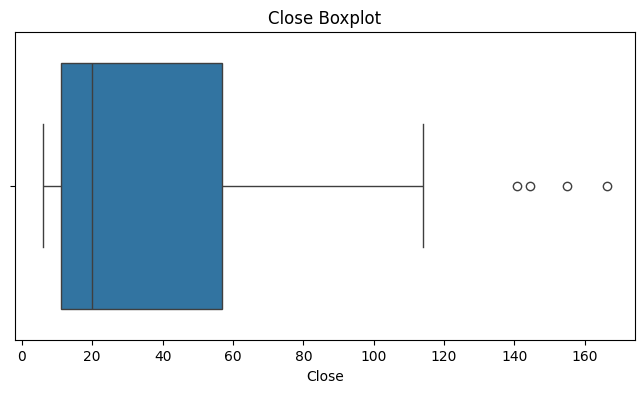

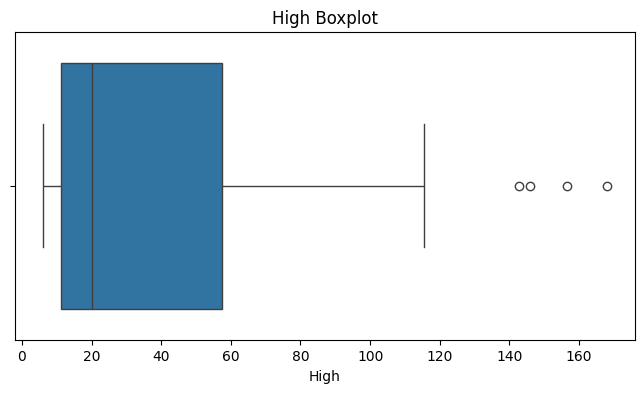

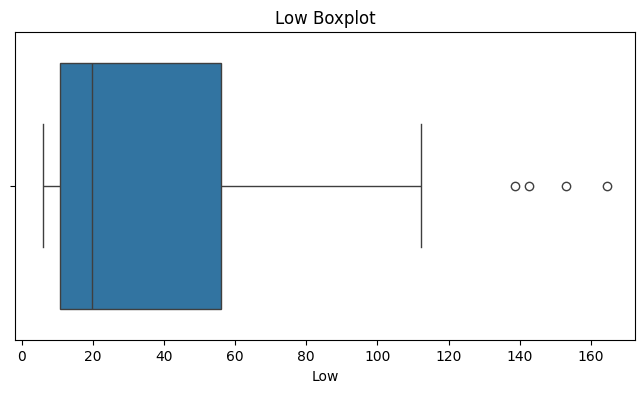

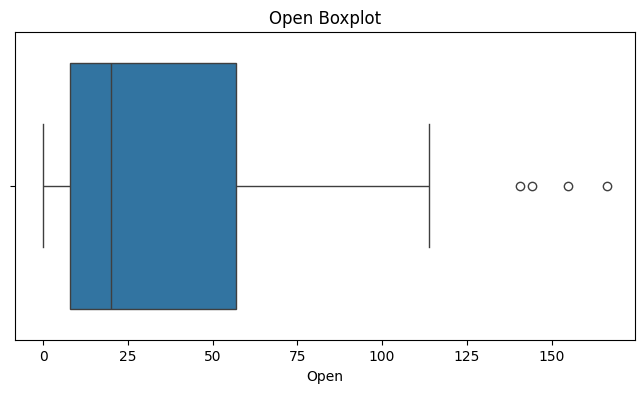

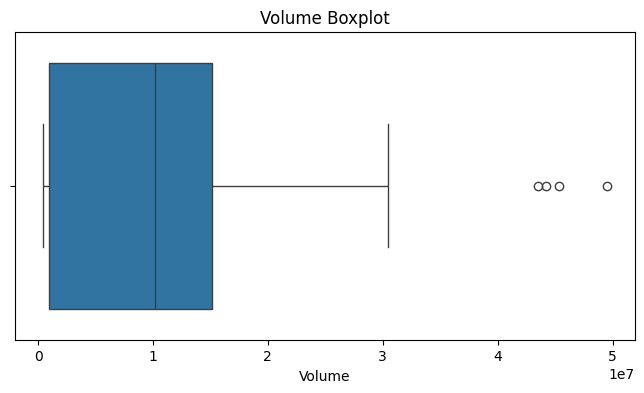

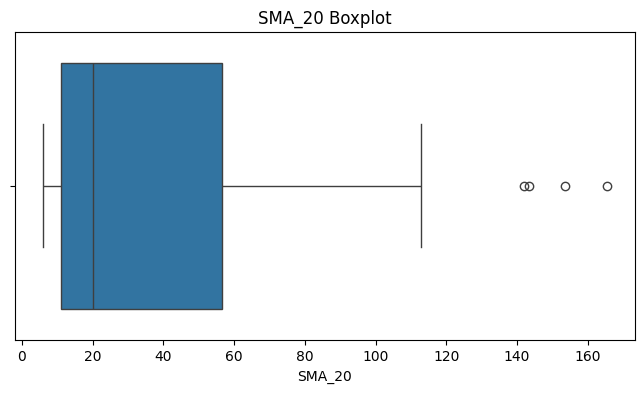

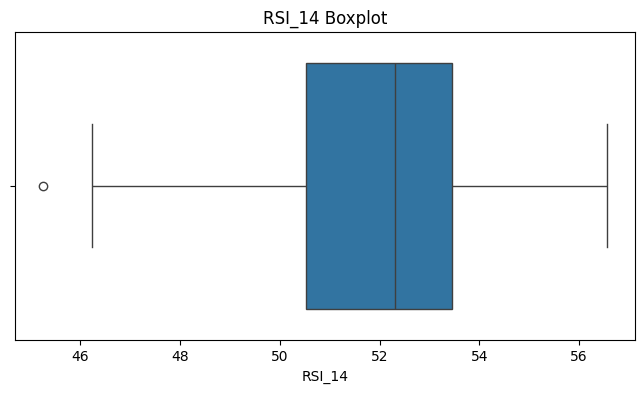

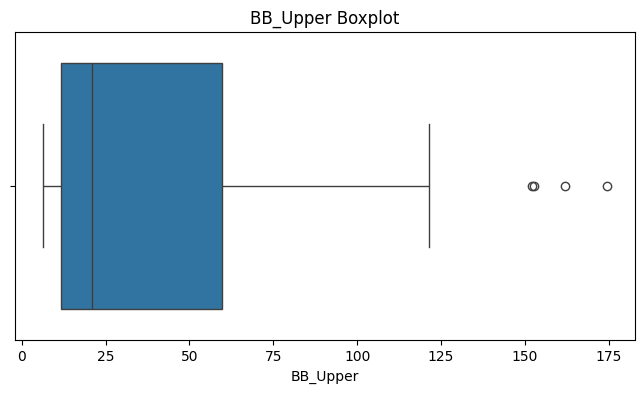

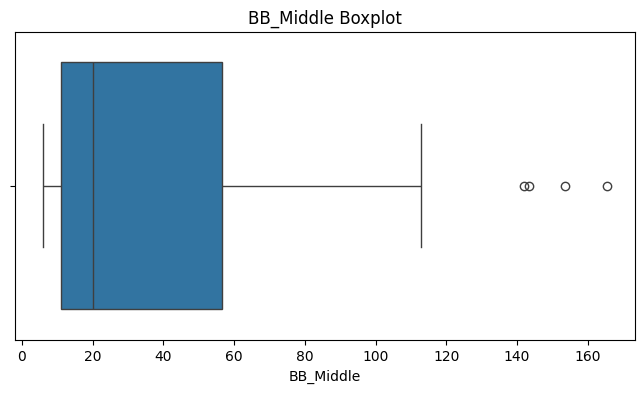

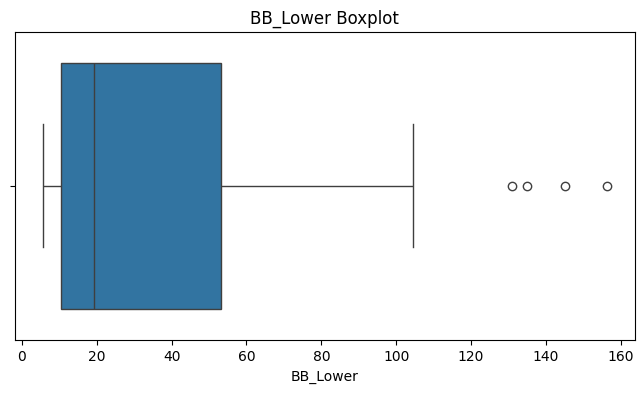

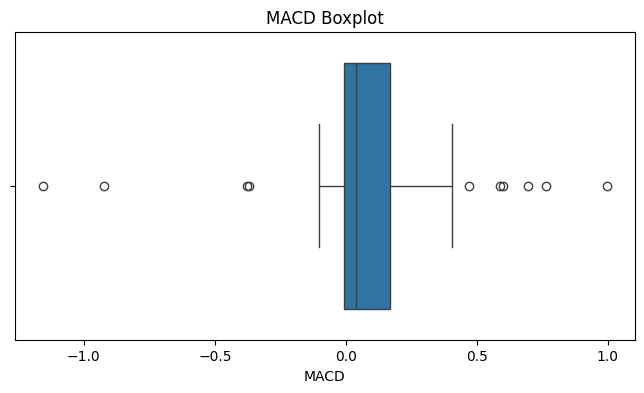

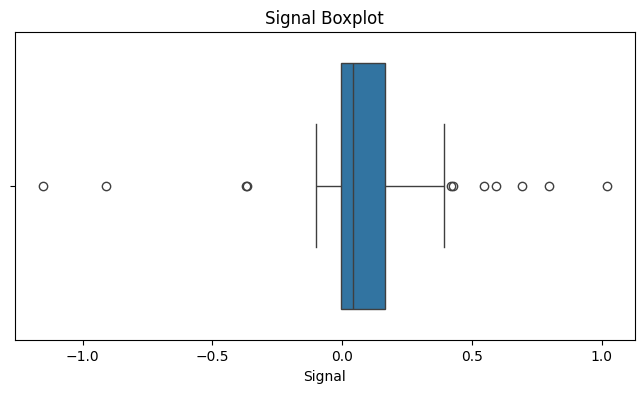

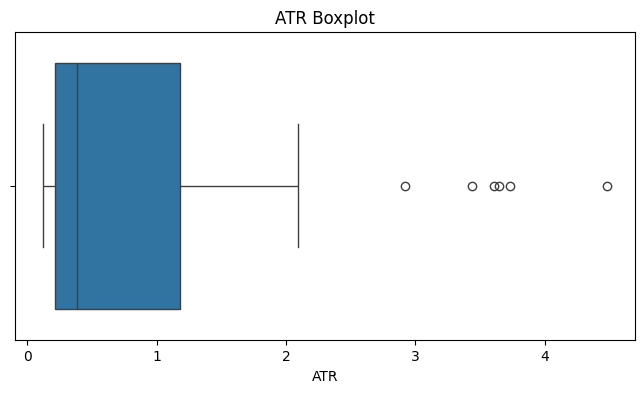

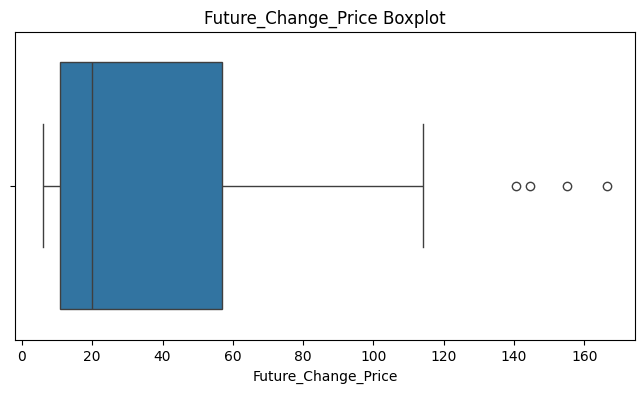

In [141]:
#create a boxplot for each feature to check for outliers
box_data = data.drop(columns=['Date', 'Ticker_ID', 'Month','Year', 'Day', 'Future_Change'])
for column in box_data.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data.groupby('Year').mean()[column])
    plt.title(f"{column} Boxplot")


In [142]:
# normalize the training data and apply the same normalization to the testing data
scaler = sk.preprocessing.MinMaxScaler()
columns_to_normalize = X_train.columns.drop(['Ticker_ID', 'Year', 'Month', 'Day'])
X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])
X_train

,Adj Close,Close,High,Low,Open,Volume,Ticker_ID,Year,Month,Day,SMA_20,RSI_14,BB_Upper,BB_Middle,BB_Lower,MACD,Signal,ATR
0,0.000449,0.001646,0.001670,0.001671,0.000000,0.000029,0,1962,2,16,0.001744,0.469625,0.001765,0.001744,0.064422,0.581622,0.591457,0.001006
1,0.000443,0.001617,0.001632,0.001648,0.000000,0.000027,0,1962,2,19,0.001746,0.412027,0.001764,0.001746,0.064426,0.581560,0.591422,0.000994
2,0.000460,0.001684,0.001682,0.001655,0.000000,0.000023,0,1962,2,20,0.001751,0.550777,0.001764,0.001751,0.064436,0.581570,0.591396,0.001065
3,0.000459,0.001677,0.001685,0.001696,0.000000,0.000017,0,1962,2,21,0.001755,0.537784,0.001764,0.001755,0.064445,0.581572,0.591376,0.001036
4,0.000454,0.001662,0.001676,0.001690,0.000000,0.000017,0,1962,2,23,0.001759,0.505665,0.001762,0.001759,0.064455,0.581557,0.591356,0.001002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416688,0.082639,0.050075,0.050507,0.050975,0.050683,0.000207,49,2017,12,22,0.055516,0.297440,0.059155,0.055516,0.110102,0.559047,0.566939,0.039979
416689,0.082568,0.050032,0.050170,0.050685,0.050006,0.000178,49,2017,12,26,0.054844,0.295967,0.056801,0.054844,0.111230,0.559316,0.566836,0.038115
416690,0.083188,0.050408,0.050676,0.050827,0.050257,0.000150,49,2017,12,27,0.054199,0.327108,0.052759,0.054199,0.114165,0.560123,0.566935,0.037168
416691,0.083578,0.050644,0.050686,0.051181,0.050591,0.000117,49,2017,12,28,0.054090,0.346661,0.052576,0.054090,0.114143,0.561214,0.567258,0.035566


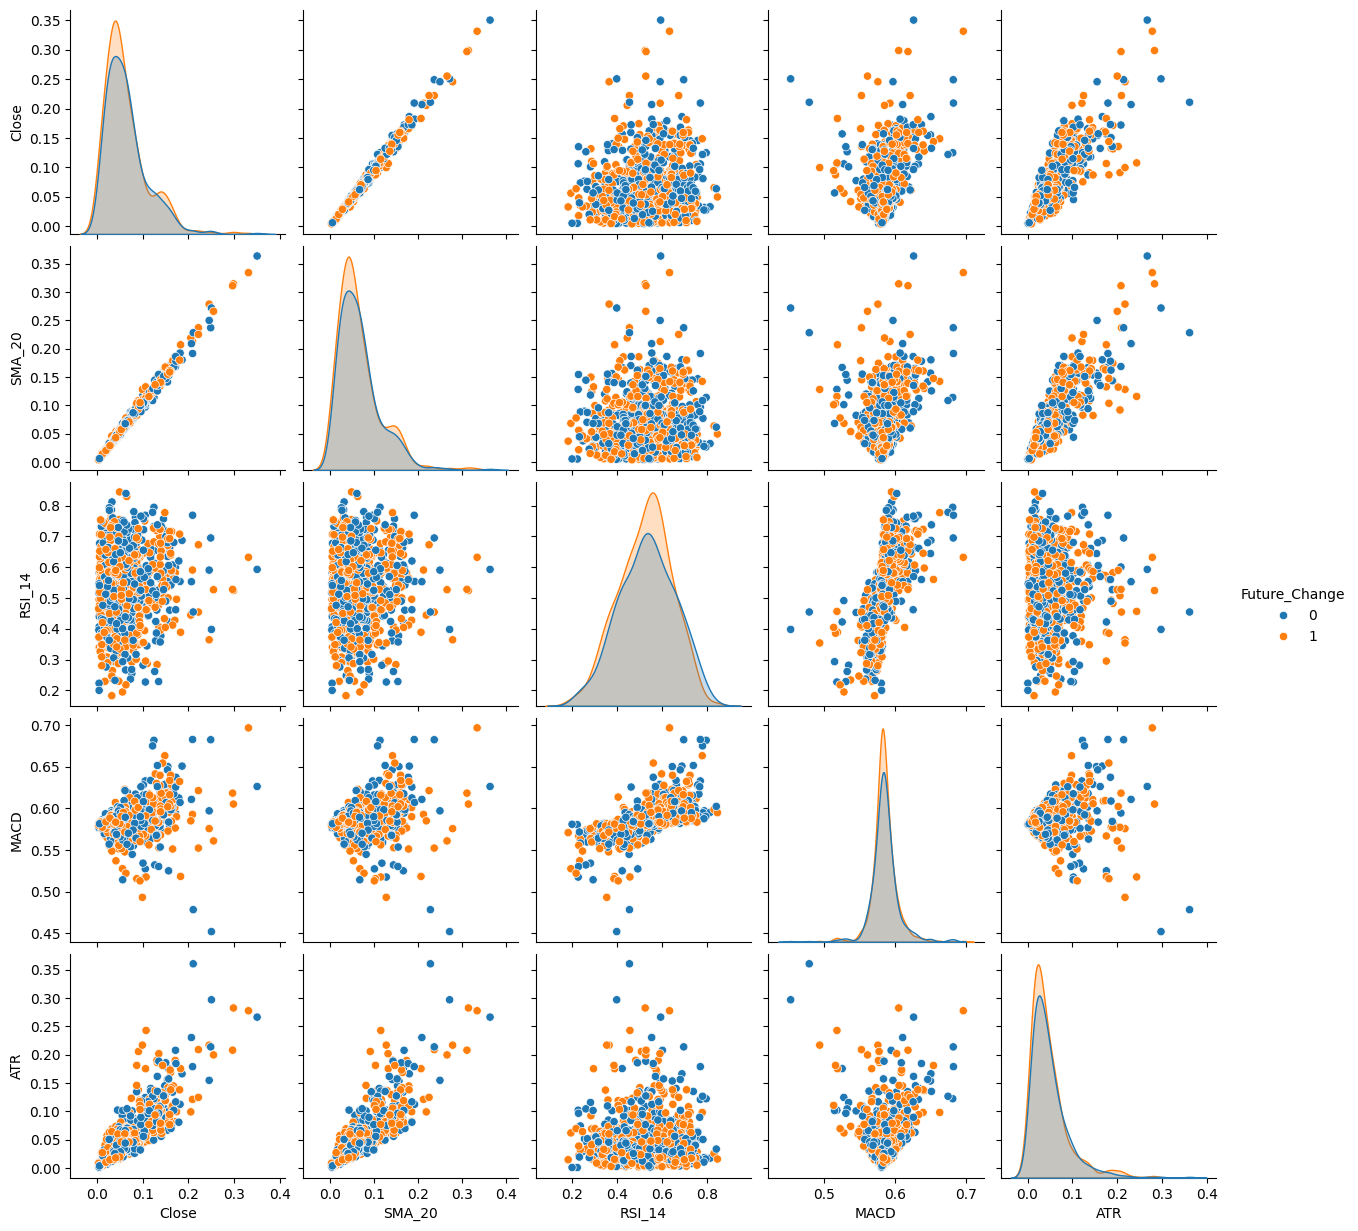

In [151]:
#create a trellis plot to visualize how certain features are correlated with the future change
trellis_data = X_test.copy()
trellis_data = trellis_data.drop(columns=['Adj Close', 'High', 'Low', 'Open', 'Year', 'Month', 'Day', 'Ticker_ID', 'Volume', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'Signal'])
trellis_data['Future_Change'] = y_test_class
trellis_data = trellis_data.sample(1000)
sns.pairplot(trellis_data, hue='Future_Change')

Accuracy for default k (842): 0.5214520278360659


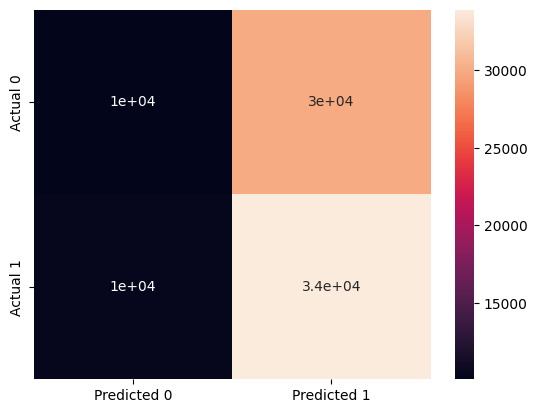

In [157]:
#Create a KNN model that will classify the future change
from numpy import sqrt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

dropped_columns = ['Year', 'Month', 'Day', 'MACD', "ATR"]
sqrt_n = sqrt(len(X_train)).astype(int) + 265
knn = KNeighborsClassifier(n_neighbors=sqrt_n, weights='distance')
knn.fit(X_train.drop(columns=dropped_columns), y_train_class)

# predict the future change
y_pred = knn.predict(X_test.drop(columns=dropped_columns))
# calculate the accuracy of the model
accuracy = accuracy_score(y_test_class, y_pred)

# confusion matrix from seaborn
confusion_matrix = pd.DataFrame(sk.metrics.confusion_matrix(y_test_class, y_pred), columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])
sns.heatmap(confusion_matrix, annot=True)

print(f"Accuracy for default k ({sqrt_n}): {accuracy}")


R2 Score: 0.9982959787267875


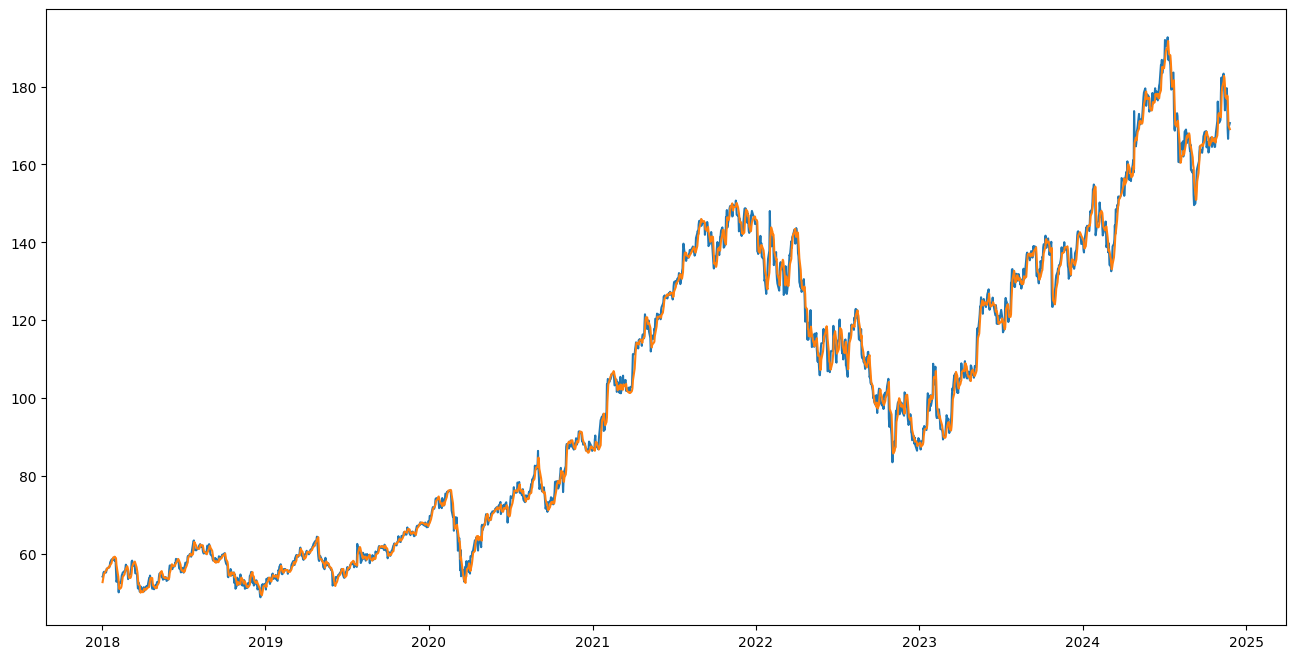

In [155]:
ticker_id = 20
X_train_new = X_train[X_train['Ticker_ID'] == ticker_id]
y_train_new = y_train[X_train_new.index]

# linear regression model
linear_regression = LinearRegression()
lr_columns = ['Close', 'Adj Close', 'High', 'Low', 'Open']
linear_regression.fit(X_train.drop(columns=lr_columns), y_train)

X_test_new = X_test[X_test['Ticker_ID'] == ticker_id]
y_test_new = y_test[X_test_new.index]


# calculate the R2 score
r2_score = linear_regression.score(X_test.drop(columns=lr_columns), y_test)
print(f"R2 Score: {r2_score}")

test_data_new = test_data[test_data['Ticker_ID'] == ticker_id]

y_pred = linear_regression.predict(X_test_new.drop(columns=lr_columns))
plt.figure(figsize=(16, 8))
plt.plot(test_data_new['Date'], y_test_new, label="Actual")
plt.plot(test_data_new['Date'], y_pred, label="Predicted")